# Exploratory Data Analysis

In [132]:
from pathlib import Path
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import shutil
import hashlib
from collections import defaultdict
import cv2
import numpy as np


## Data Quality Checks
The code cell below is making sure all images are in the same format and same mode.

In [133]:
# Notebook is in notebooks/
# Data is in ../data/interim/
# Make sure to adjust the path accordingly
DATA_DIR = Path("../data/interim")

# Making sure all images same format
extensions = []

for path in DATA_DIR.rglob("*"):
    if path.is_file():
        extensions.append(path.suffix.lower())

extension_counts = Counter(extensions)

# image mode
image_paths = list(DATA_DIR.rglob("*.jpg"))
modes = []
for img_path in tqdm(image_paths, desc="Checking image color modes"):
    with Image.open(img_path) as img:
        modes.append(img.mode)

mode_counts = Counter(modes)
print(mode_counts)
print(extension_counts)




Checking image color modes: 100%|██████████| 25553/25553 [00:00<00:00, 36010.50it/s]

Counter({'RGB': 25553})
Counter({'.jpg': 25553, '.csv': 2, '.yaml': 1, '': 1})


All iamges are .jpg format and are in RGB mode.

### File corruption

In [134]:
DATA_DIR = Path("../data/interim")

image_paths = list(DATA_DIR.rglob("*.jpg"))

corrupt_images = []

for img_path in tqdm(image_paths, desc="Checking images"):
    try:
        with Image.open(img_path) as img:
            img.verify()  # verifies file integrity
    except Exception:
        corrupt_images.append(img_path)

print(f"Total images checked: {len(image_paths)}")
print(f"Corrupt images found: {len(corrupt_images)}")

Checking images: 100%|██████████| 25553/25553 [00:00<00:00, 35793.38it/s]

Total images checked: 25553
Corrupt images found: 0


### Duplicates
The next code cell use md5 hash function to duplicate files in the datasets.

In [135]:
DATA_DIR = Path("../data/interim")

image_paths = list(DATA_DIR.rglob("*.jpg"))

def file_md5(path, chunk_size=8192):
    md5 = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            md5.update(chunk)
    return md5.hexdigest()

hash_to_paths = defaultdict(list)

for p in tqdm(image_paths, desc="Hashing files"):
    h = file_md5(p)
    hash_to_paths[h].append(p)

# Keep only hashes with more than one file (true duplicates)
file_duplicates = {
    h: paths for h, paths in hash_to_paths.items() if len(paths) > 1
}

print(f"File-level duplicate groups: {len(file_duplicates)}")


Hashing files: 100%|██████████| 25553/25553 [00:04<00:00, 5505.97it/s] 

File-level duplicate groups: 5591


Surprisingly, the method found 5591 pair of duplicate files. 
Next code chunk creates a dataframe for the duplicate files with information about their path, split and class.
Using this information, a decision can be made to see if any logic can be applied to save as much data as possible.

In [136]:
rows = []

for h, paths in file_duplicates.items():
    if len(paths) >= 2:
        rows.append({
            "hash": h,
            "num_files": len(paths),
            "path_1": str(paths[0]),
            "path_2": str(paths[1])
        })

file_duplicates_pair_df = pd.DataFrame(rows)

def extract_split_and_class(path_str):
    path = Path(path_str)
    parts = path.parts
    idx = parts.index("interim")
    split = parts[idx + 1]
    cls = parts[idx + 2]
    return split, cls

# Apply extraction
file_duplicates_pair_df[["split_1", "class_1"]] = (
    file_duplicates_pair_df["path_1"]
    .apply(lambda p: pd.Series(extract_split_and_class(p)))
)

file_duplicates_pair_df[["split_2", "class_2"]] = (
    file_duplicates_pair_df["path_2"]
    .apply(lambda p: pd.Series(extract_split_and_class(p)))
)


file_duplicates_pair_df.to_csv("../data/interim/file_duplicates.csv", index=False)
file_duplicates_pair_df

,hash,num_files,path_1,path_2,split_1,class_1,split_2,class_2
0,5cd88f93817d8ad7203345747613ddd8,2,../data/interim/test/normal/normal-491.jpg,../data/interim/train/tuberculosis/tuberculosi...,test,normal,train,tuberculosis
1,b7decde86a97411de05f96cf8aeae544,2,../data/interim/test/normal/normal-696.jpg,../data/interim/train/pneumonia/pneumonia-3824...,test,normal,train,pneumonia
2,36d1e38cc3293841e3c221229695420e,2,../data/interim/test/normal/normal-131.jpg,../data/interim/train/pneumonia/pneumonia-1315...,test,normal,train,pneumonia
3,afce02b448fd06d3bc81065e31bd91f0,2,../data/interim/test/normal/normal-328.jpg,../data/interim/train/tuberculosis/tuberculosi...,test,normal,train,tuberculosis
4,790e2ea9208f08d4191aa9759fa079c9,2,../data/interim/test/normal/normal-715.jpg,../data/interim/test/tuberculosis/tuberculosis...,test,normal,test,tuberculosis
...,...,...,...,...,...,...,...,...
5586,2512fafcefc442b31127f14d5addc076,2,../data/interim/val/normal/normal-8307.jpg,../data/interim/val/tuberculosis/tuberculosis-...,val,normal,val,tuberculosis
5587,682b28b90f797032e71287b13c25997d,2,../data/interim/val/normal/normal-8945.jpg,../data/interim/val/tuberculosis/tuberculosis-...,val,normal,val,tuberculosis
5588,fbd068cb6a6dd20287e238e6c12ac226,2,../data/interim/val/normal/normal-8657.jpg,../data/interim/val/tuberculosis/tuberculosis-...,val,normal,val,tuberculosis
5589,91cb5ddb940bec37c67894b58631cda7,2,../data/interim/val/normal/normal-8388.jpg,../data/interim/val/tuberculosis/tuberculosis-...,val,normal,val,tuberculosis


Unfortunately, any logic to delete one of the duplicates arbritaly will not be supported by any evidence. Two of same image with two different classes, one of them must be wrong! Keeping the image with the wrong label will have high cost on the training. My thougths now is to be keep only duplicates with the same class.

In [137]:
same_class_df = file_duplicates_pair_df[
    file_duplicates_pair_df["class_1"] == file_duplicates_pair_df["class_2"]
    
]

same_class_df 

,hash,num_files,path_1,path_2,split_1,class_1,split_2,class_2
594,0c0a0c84e6703607bf94a9f5a60cfe6c,2,../data/interim/test/tuberculosis/tuberculosis...,../data/interim/val/tuberculosis/tuberculosis-...,test,tuberculosis,val,tuberculosis
5123,8d5989c65553767d9aaa58694d21818c,2,../data/interim/train/tuberculosis/tuberculosi...,../data/interim/train/tuberculosis/tuberculosi...,train,tuberculosis,train,tuberculosis
5590,438bb76c5106fe5e40ef49901f1a93e6,2,../data/interim/val/tuberculosis/tuberculosis-...,../data/interim/val/tuberculosis/tuberculosis-...,val,tuberculosis,val,tuberculosis


Ok. It turned out, only 3 duplicates have the same class. I will prioritze to keep images (if same class)  from train then val then test. 

In [149]:
# create a new directory for deduped data
SRC_DIR = Path("../data/interim")
DST_DIR = Path("../data/interim_deduped")

if not DST_DIR.exists():
    shutil.copytree(SRC_DIR, DST_DIR)

# Set split priority
SPLIT_PRIORITY = {"train": 0, "val": 1, "test": 2}

paths_to_delete = []

for _, row in file_duplicates_pair_df.iterrows():
    p1, p2 = row["path_1"], row["path_2"]

    # Case 1: conflicting classes → delete both
    if row["class_1"] != row["class_2"]:
        paths_to_delete.extend([p1, p2])
        continue

    # Case 2: same class
    if row["split_1"] == row["split_2"]:
        # delete whichever comes first alphabetically; this so it is reproducible!
        delete_path = min(p1, p2)
    else:
        # keep by split priority: train > val > test
        keep_path = (
            p1 if SPLIT_PRIORITY[row["split_1"]] < SPLIT_PRIORITY[row["split_2"]] else p2
        )
        delete_path = p2 if keep_path == p1 else p1

    paths_to_delete.append(delete_path)

# Perform deletion only in the copied dataset
deleted = 0
for p in paths_to_delete:
    fp = Path(p.replace("data/interim", "data/interim_deduped"))
    if fp.exists():
        fp.unlink()
        deleted += 1

print(f"Deleted {deleted} files from interim_deduped.")


Deleted 11179 files from interim_deduped.


### Image Quality 
In the code cell below, I calculate laplacian variance, signal-to-noise ratio and RMS contrast for all images. The purpose of this is to flag images that may exhibit bluriness or excessive noise. I hesitate with medical images to exclude images just based on numerical threshold becuase of the extreme variations and the lack of reference. So visual inspection is used as the final decision step before any exclusion, ensuring that clinically/anatomically interpretable images are removed.

In [150]:
DATA_DIR = Path("../data/interim_deduped")
image_paths = list(DATA_DIR.rglob("*.jpg"))

records = []

for p in tqdm(image_paths, desc="Computing image quality metrics"):
    img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    rms_contrast = img.std()
    noise = rms_contrast
    snr = img.mean() / noise if noise > 0 else np.nan

    records.append({
        "path": str(p),
        "laplacian_var": laplacian_var,
        "snr": snr,
        "rms_contrast": rms_contrast
    })

image_quality_df = pd.DataFrame(records)
image_quality_df.to_csv("../data/interim_deduped/image_quality_metrics.csv", index=False)
image_quality_df.head()

Computing image quality metrics: 100%|██████████| 14374/14374 [01:56<00:00, 123.35it/s]


,path,laplacian_var,snr,rms_contrast
0,../data/interim_deduped/test/normal/normal-792...,61.007967,1.784835,68.974630
1,../data/interim_deduped/test/normal/normal-877...,176.581322,2.447373,47.344382
2,../data/interim_deduped/test/normal/normal-354...,284.730246,2.191697,72.668029
3,../data/interim_deduped/test/normal/normal-753...,40.229906,1.456983,67.482956
4,../data/interim_deduped/test/normal/normal-730...,60.081955,1.977993,67.972127


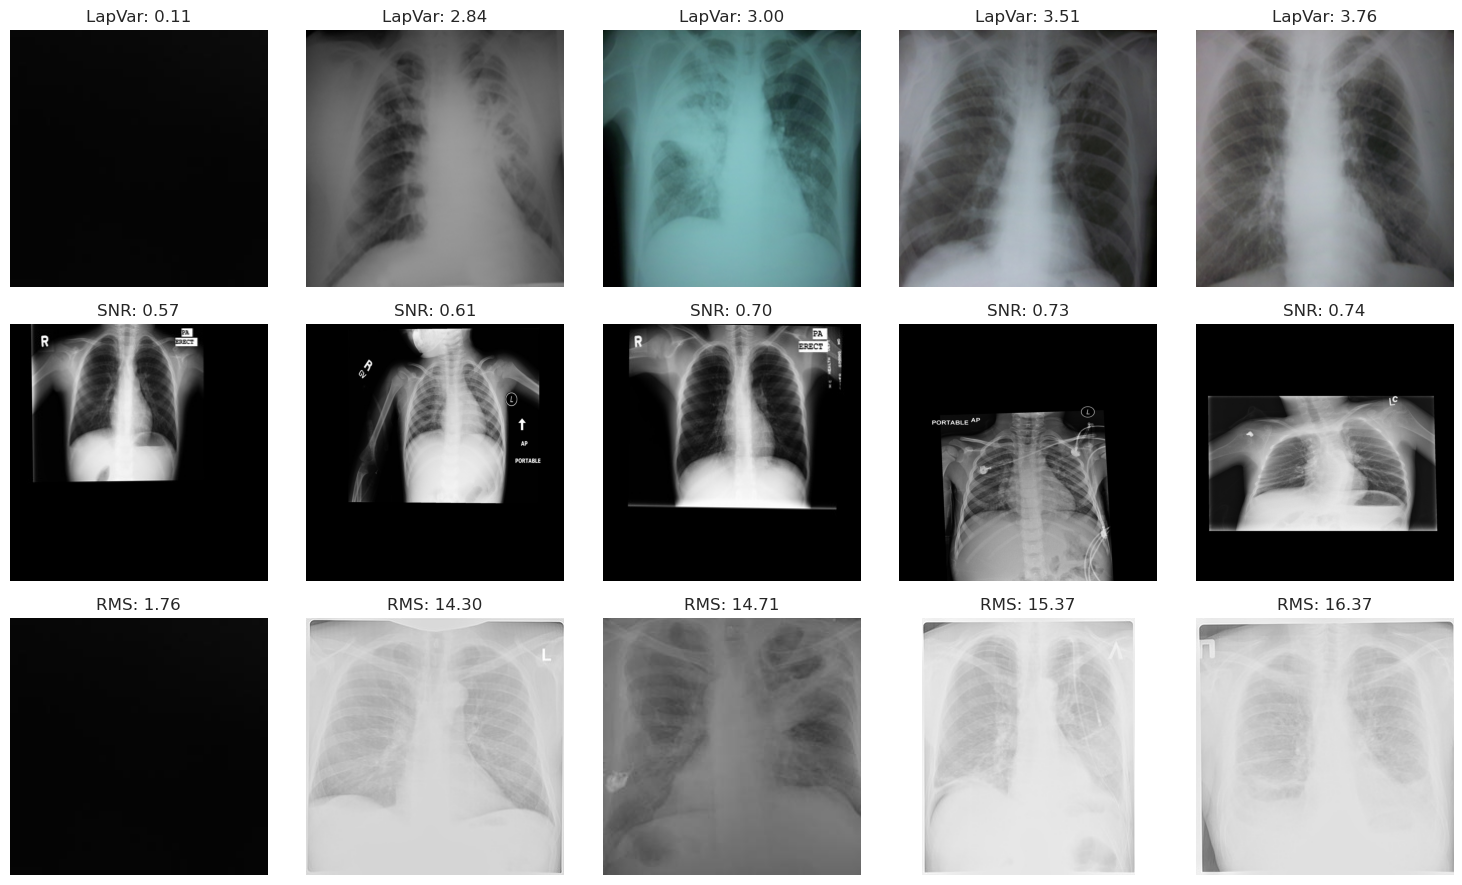

In [151]:

# Select lowest 5 for each metric
lowest_lap = image_quality_df.sort_values("laplacian_var").head(5)
lowest_snr = image_quality_df.sort_values("snr").head(5)
lowest_rms = image_quality_df.sort_values("rms_contrast").head(5)

fig, axes = plt.subplots(3, 5, figsize=(15, 9))

# Row 1: Lowest Laplacian variance
for ax, (_, row) in zip(axes[0], lowest_lap.iterrows()):
    img = Image.open(row["path"])
    ax.imshow(img, cmap="gray")
    ax.set_title(f"LapVar: {row['laplacian_var']:.2f}")
    ax.axis("off")

# Row 2: Lowest SNR
for ax, (_, row) in zip(axes[1], lowest_snr.iterrows()):
    img = Image.open(row["path"])
    ax.imshow(img, cmap="gray")
    ax.set_title(f"SNR: {row['snr']:.2f}")
    ax.axis("off")

# Row 3: Lowest RMS contrast
for ax, (_, row) in zip(axes[2], lowest_rms.iterrows()):
    img = Image.open(row["path"])
    ax.imshow(img, cmap="gray")
    ax.set_title(f"RMS: {row['rms_contrast']:.2f}")
    ax.axis("off")

axes[0, 0].set_ylabel("Lowest Laplacian", fontsize=12)
axes[1, 0].set_ylabel("Lowest SNR", fontsize=12)
axes[2, 0].set_ylabel("Lowest RMS", fontsize=12)

plt.tight_layout()
plt.show()

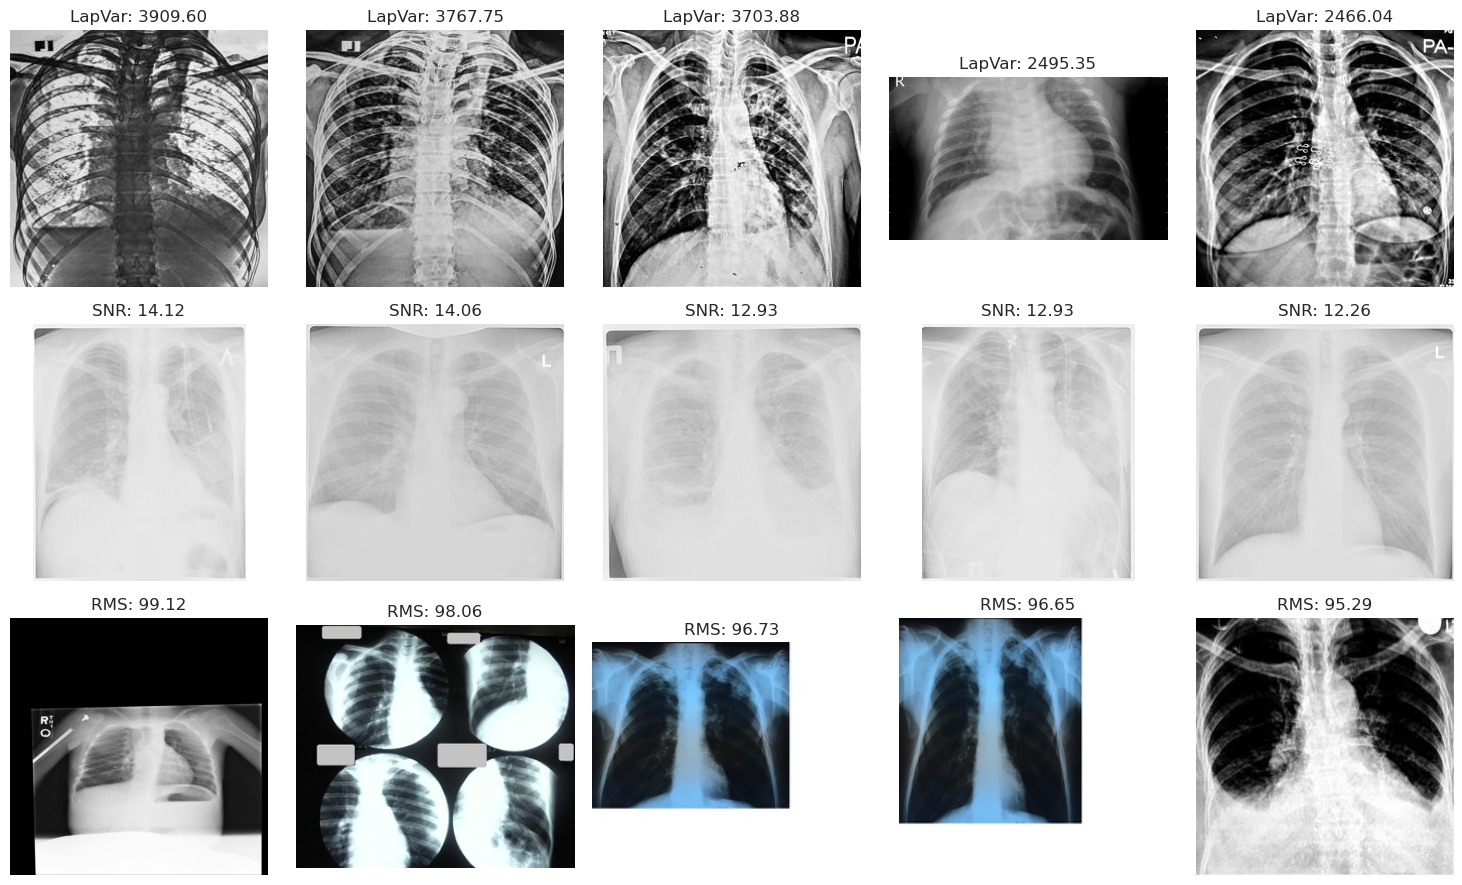

In [152]:
# Select highest 5 for each metric
highest_lap = image_quality_df.sort_values("laplacian_var", ascending=False).head(5)
highest_snr = image_quality_df.sort_values("snr", ascending=False).head(5)
highest_rms = image_quality_df.sort_values("rms_contrast",  ascending=False).head(5)

fig, axes = plt.subplots(3, 5, figsize=(15, 9))

# Row 1: Highest Laplacian variance
for ax, (_, row) in zip(axes[0], highest_lap.iterrows()):
    img = Image.open(row["path"])
    ax.imshow(img, cmap="gray")
    ax.set_title(f"LapVar: {row['laplacian_var']:.2f}")
    ax.axis("off")

# Row 2: Highest SNR
for ax, (_, row) in zip(axes[1], highest_snr.iterrows()):
    img = Image.open(row["path"])
    ax.imshow(img, cmap="gray")
    ax.set_title(f"SNR: {row['snr']:.2f}")
    ax.axis("off")

# Row 3: Highest RMS contrast
for ax, (_, row) in zip(axes[2], highest_rms.iterrows()):
    img = Image.open(row["path"])
    ax.imshow(img, cmap="gray")
    ax.set_title(f"RMS: {row['rms_contrast']:.2f}")
    ax.axis("off")

axes[0, 0].set_ylabel("Highest Laplacian", fontsize=12)
axes[1, 0].set_ylabel("Highest SNR", fontsize=12)
axes[2, 0].set_ylabel("Highest RMS", fontsize=12)

plt.tight_layout()
plt.show()

In [153]:
# Get the single worst image by Laplacian and RMS
worst_lap_path = image_quality_df.sort_values("laplacian_var").iloc[0]["path"]
worst_rms_path = image_quality_df.sort_values("rms_contrast").iloc[0]["path"]

paths_to_delete = set([worst_lap_path, worst_rms_path])

paths_to_delete.update(
    image_quality_df.sort_values("rms_contrast", ascending=False)
    .head(2)["path"]
)

paths_to_delete

deleted = 0

for p in paths_to_delete:
    fp = Path(p)
    if fp.exists():
        fp.unlink()
        deleted += 1
print(f"Deleted {deleted} images")

Deleted 3 images


Next cell assess blockiness that happens due to image compression. they are used here to flag images for inspection.

In [154]:
def blockiness_index(img):
    h, w = img.shape
    h8, w8 = (h//8)*8, (w//8)*8
    img8 = img[:h8, :w8].reshape(h8//8, 8, w8//8, 8)
    diffs = np.abs(img8[:, :-1, :, :] - img8[:, 1:, :, :]).mean()
    return diffs

records = []
for p in tqdm(image_paths):
    img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    if img is None or img.shape[0] < 16 or img.shape[1] < 16:
        continue
    bi = blockiness_index(img)
    records.append({"path": str(p), "blockiness": bi})

block_df = pd.DataFrame(records)
block_df.to_csv("../data/interim_deduped/image_blockiness_metrics.csv", index=False)

block_df.head()


100%|██████████| 14374/14374 [01:06<00:00, 215.28it/s]


,path,blockiness
0,../data/interim_deduped/test/normal/normal-792...,97.473154
1,../data/interim_deduped/test/normal/normal-877...,88.819374
2,../data/interim_deduped/test/normal/normal-354...,99.363299
3,../data/interim_deduped/test/normal/normal-753...,99.483634
4,../data/interim_deduped/test/normal/normal-730...,109.252138


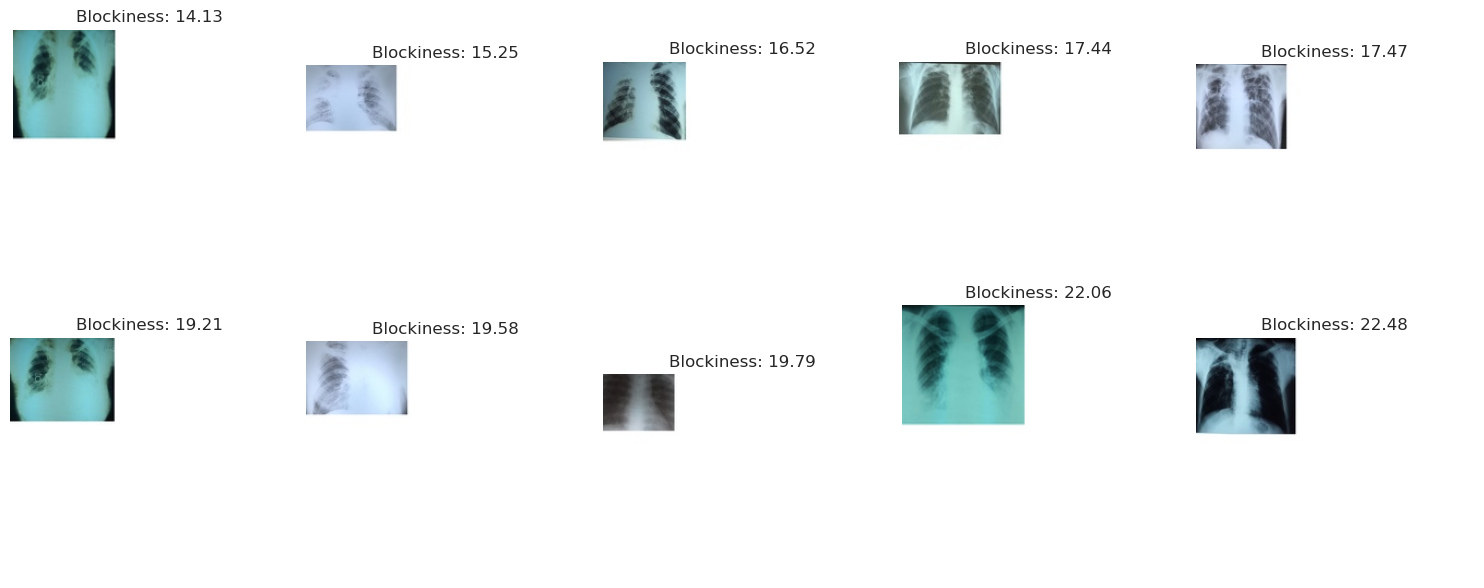

In [155]:

top_block_df = block_df.sort_values("blockiness").head(10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax, (_, row) in zip(axes.flatten(), top_block_df.iterrows()):
    img = Image.open(row["path"])
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Blockiness: {row['blockiness']:.2f}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [156]:

# Select paths to delete
paths_to_delete = block_df.loc[block_df["blockiness"] < 40, "path"]

deleted = 0
for p in paths_to_delete:
    fp = Path(p)
    if fp.exists():
        fp.unlink()
        deleted += 1

print(f"Deleted {deleted} images with blockiness < 40")


Deleted 37 images with blockiness < 40


### Image size
Inspecting image size and aspect ratio.

In [157]:
DATA_DIR = Path("../data/interim_deduped")

records = []

image_paths = list(DATA_DIR.rglob("*.jpg"))

for p in tqdm(image_paths, desc="Reading image sizes"):
    with Image.open(p) as img:
        width, height = img.size
        parts = p.parts
        idx = parts.index("interim_deduped")
        split = parts[idx + 1]
        cls = parts[idx + 2]

        records.append({
            "path": str(p),
            "split": split,
            "class": cls,
            "width": width,
            "height": height,
            "aspect_ratio": width / height,
            "area": width * height
        })

sizes_df = pd.DataFrame(records)
sizes_df.head()


sizes_df.to_csv("../data/interim_deduped/image_sizes.csv", index=False)
sizes_df.head()


Reading image sizes: 100%|██████████| 14334/14334 [00:00<00:00, 30098.47it/s]


,path,split,class,width,height,aspect_ratio,area
0,../data/interim_deduped/test/normal/normal-792...,test,normal,1024,1024,1.0,1048576
1,../data/interim_deduped/test/normal/normal-877...,test,normal,1024,1024,1.0,1048576
2,../data/interim_deduped/test/normal/normal-354...,test,normal,1024,1024,1.0,1048576
3,../data/interim_deduped/test/normal/normal-753...,test,normal,1024,1024,1.0,1048576
4,../data/interim_deduped/test/normal/normal-730...,test,normal,1024,1024,1.0,1048576


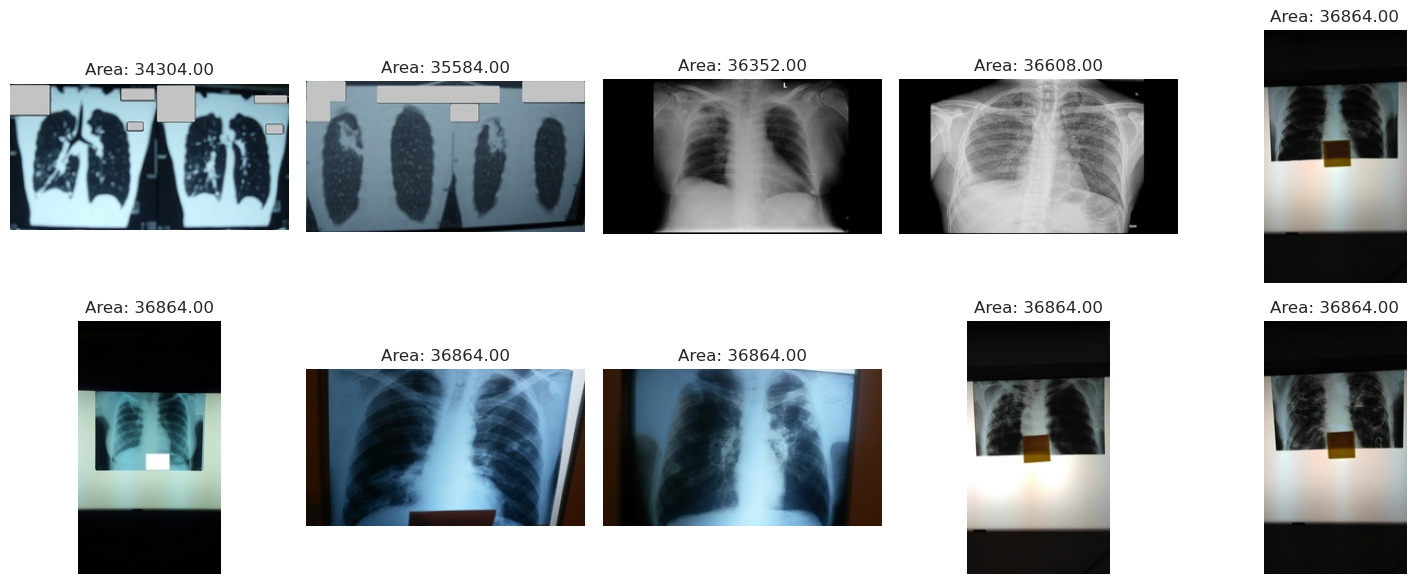

In [160]:
top_sizes_df = sizes_df.sort_values("area").head(10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax, (_, row) in zip(axes.flatten(), top_sizes_df.iterrows()):
    img = Image.open(row["path"])
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Area: {row['area']:.2f}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [161]:
# Select paths to delete
paths_to_delete = sizes_df.loc[sizes_df["area"] < 40000, "path"]

deleted = 0
for p in paths_to_delete:
    fp = Path(p)
    if fp.exists():
        fp.unlink()
        deleted += 1

print(f"Deleted {deleted} images with area < 40000")


Deleted 24 images with area < 40000


### Distribution of class per split

The code cell below is fetching number of images per split per class and creating visualizations.

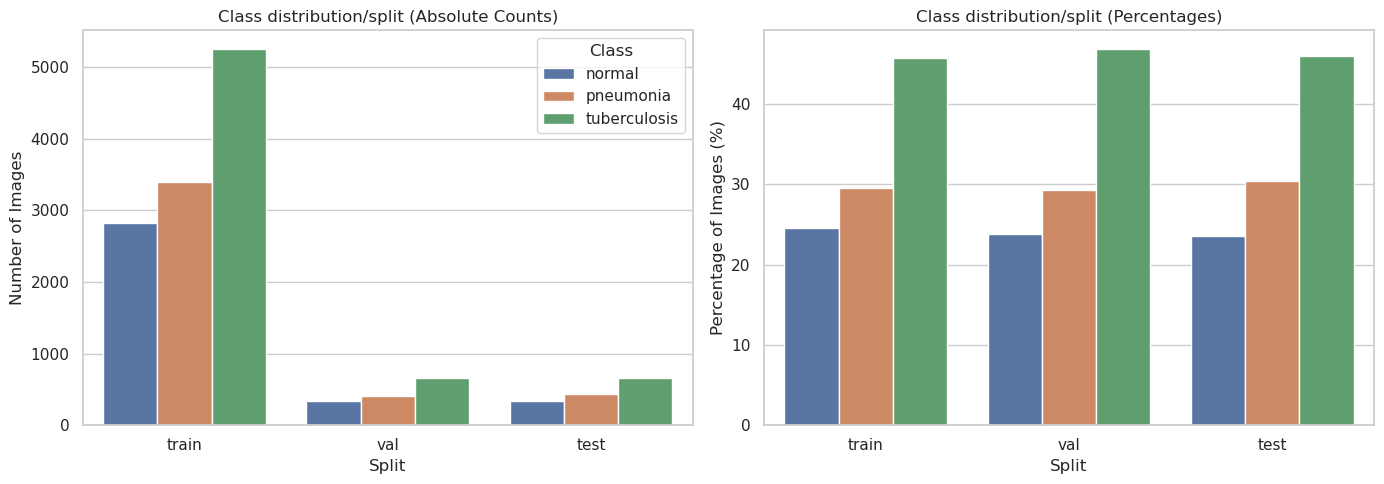

In [162]:
DATA_DIR = Path("../data/interim_deduped")

splits = ["train", "val", "test"]
classes = ["normal", "pneumonia", "tuberculosis"]

records = []

for split in splits:
    for cls in classes:
        class_dir = DATA_DIR / split / cls
        num_images = len(list(class_dir.glob("*.jpg")))
        
        records.append({
            "split": split,
            "class": cls,
            "num_images": num_images
        })

counts_df = pd.DataFrame(records)

# Save to CSV
counts_df.to_csv("../data/interim_deduped/class_counts.csv", index=False)



# Compute percentages within each split
counts_pct_df = counts_df.copy()
counts_pct_df["percent"] = (
    counts_pct_df
    .groupby("split")["num_images"]
    .transform(lambda x: x / x.sum() * 100)
)



sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# --- Plot 1: Absolute counts ---
sns.barplot(
    data=counts_df,
    x="split",
    y="num_images",
    hue="class",
    ax=axes[0]
)
axes[0].set_title("Class distribution/split (Absolute Counts)")
axes[0].set_xlabel("Split")
axes[0].set_ylabel("Number of Images")

# --- Plot 2: Percentages ---
sns.barplot(
    data=counts_pct_df,
    x="split",
    y="percent",
    hue="class",
    ax=axes[1]
)
axes[1].set_title("Class distribution/split (Percentages)")
axes[1].set_xlabel("Split")
axes[1].set_ylabel("Percentage of Images (%)")

# Handle legends (avoid duplication)
axes[0].legend(title="Class")
axes[1].legend_.remove()

plt.tight_layout()
plt.show()

Given the table/figures above, I will keep the current split. The reasons for this are:
a- the split contains all classes,
b- close proportions of each class across splits,
c- keep comparability with existing work,
d- lack of patient metadata to actually make informative re-splitting.

Having that said, there is clear class imbalance on the dataset-level (not the split-level).